In [1]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d jigrubhatt/selfieimagedetectiondataset


 99% 2.80G/2.81G [00:31<00:00, 82.0MB/s]
100% 2.81G/2.81G [00:31<00:00, 96.7MB/s]


In [2]:
!unzip /content/selfieimagedetectiondataset.zip -d dataset

Streaming output truncated to the last 5000 lines.
  inflating: dataset/Selfie-Image-Detection-Dataset/Validation_data/NonSelfie/NonSelfie26784.jpg  
  inflating: dataset/Selfie-Image-Detection-Dataset/Validation_data/NonSelfie/NonSelfie26785.jpg  
  inflating: dataset/Selfie-Image-Detection-Dataset/Validation_data/NonSelfie/NonSelfie26786.jpg  
  inflating: dataset/Selfie-Image-Detection-Dataset/Validation_data/NonSelfie/NonSelfie26787.jpg  
  inflating: dataset/Selfie-Image-Detection-Dataset/Validation_data/NonSelfie/NonSelfie26788.jpg  
  inflating: dataset/Selfie-Image-Detection-Dataset/Validation_data/NonSelfie/NonSelfie26789.jpg  
  inflating: dataset/Selfie-Image-Detection-Dataset/Validation_data/NonSelfie/NonSelfie26790.jpg  
  inflating: dataset/Selfie-Image-Detection-Dataset/Validation_data/NonSelfie/NonSelfie26791.jpg  
  inflating: dataset/Selfie-Image-Detection-Dataset/Validation_data/NonSelfie/NonSelfie26792.jpg  
  inflating: dataset/Selfie-Image-Detection-Dataset/Valida

In [3]:
# import the necessary packages
import os
from os import listdir
from os.path import isfile, join
# initialize the path to the *original* input directory of images
ORIG_INPUT_DATASET = "../content/dataset/Selfie-Image-Detection-Dataset"
# initialize the base path to the *new* directory that will contain
# our images after computing the training and testing split
BASE_PATH = "."


# define the names of the training, testing, and validation
# directories
TRAIN = "Training_data"
TEST = "Test_data"
VAL = "Validation_data"
# initialize the list of class label names
CLASSES = ["Selfie", "NonSelfie"]
# set the batch size
BATCH_SIZE = 32
INIT_LR = 1e-4


# initialize the label encoder file path and the output directory to
# where the extracted features (in CSV file format) will be stored
LE_PATH = os.path.sep.join(["./output", "le.cpickle"])
BASE_CSV_PATH = "./output"
# set the path to the serialized model after training
MODEL_PATH = os.path.sep.join(["./output", "model.cpickle"])

# define the path to the output training history plots
UNFROZEN_PLOT_PATH = os.path.sep.join(["./output", "unfrozen.png"])
WARMUP_PLOT_PATH = os.path.sep.join(["./output", "warmup.png"])

In [4]:
!pip install imutils

In [5]:
# import the necessary packages
from imutils import paths
import shutil
import os
import random
# loop over the data splits
for split in (TRAIN, TEST):
    # grab all image paths in the current split
    print("[INFO] processing '{} split'..................".format(split))
    p = os.path.sep.join([ORIG_INPUT_DATASET, split])
    imagePaths = list(paths.list_images(p))

    # loop over the image paths
    for imagePath in imagePaths:
        # extract class label from the filename
        filename = imagePath.split(os.path.sep)[-1]

        label = imagePath.split(os.path.sep)[-2]
        # construct the path to the output directory
        dirPath = os.path.sep.join([BASE_PATH, split, label])

        # if the output directory does not exist, create it
        if not os.path.exists(dirPath):
            os.makedirs(dirPath)
        # construct the path to the output image file and copy it
        p = os.path.sep.join([dirPath, filename])

        shutil.copy2(imagePath, p)

[INFO] processing 'Training_data split'..................
[INFO] processing 'Test_data split'..................


In [6]:
source = join(BASE_PATH, TEST)#os.path.sep.join([BASE_PATH, TEST])
target = join(BASE_PATH, VAL)

for Type in CLASSES:
    sourcePath = join(source, Type)
    targetPath = join(target, Type)

    if not os.path.exists(targetPath):
        os.makedirs(targetPath)

    print(f"Sourse Path: {sourcePath}\nTarget Path: {targetPath}\n")

    imagePaths = list(paths.list_images(sourcePath))
    random.shuffle(imagePaths)
    mid = int(len(imagePaths) / 2)
    imagePaths = imagePaths[: mid]

    for imagePath in imagePaths:
        filename = imagePath.split(os.path.sep)[-1]

        shutil.copy2(imagePath, join(targetPath,filename))
        os.remove(imagePath)

Sourse Path: ./Test_data/Selfie
Target Path: ./Validation_data/Selfie

Sourse Path: ./Test_data/NonSelfie
Target Path: ./Validation_data/NonSelfie



In [7]:
print(f"Train Data: {len(list(paths.list_images(join(BASE_PATH, TRAIN))))}")
print(f"Validation Data: {len(list(paths.list_images(join(BASE_PATH, VAL))))}")
print(f"Test Data: {len(list(paths.list_images(join(BASE_PATH, TEST))))}")

Train Data: 62895
Validation Data: 3930
Test Data: 3932


Implementing fine-tuning with Keras

In [8]:
def plot_training(H, N, plotPath):
    %matplotlib inline
    # construct a plot that plots and saves the training history
    fig, (accuracy, loss) = plt.subplots(1, 2)
    fig.suptitle('Training Loss and Accuracy')
    fig.tight_layout()
    plt.subplots_adjust(wspace = 0.5)
    plt.style.use("ggplot")
    plt.figure()
    loss.plot(np.arange(0, N), H.history["loss"], label="train_loss")
    loss.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
    loss.set_title('Training Loss')
    loss.set_xlabel('Epoch #')
    loss.set_ylabel('Loss')
    loss.legend(loc="upper right")
    accuracy.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
    accuracy.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
    accuracy.set_title('Training Accuracy')
    accuracy.set_xlabel('Epoch #')
    accuracy.set_ylabel('Accuracy')
    accuracy.legend(loc="lower right")
    fig.savefig(plotPath)

In [9]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [10]:
# derive the paths to the training, validation, and testing
# directories
trainPath = os.path.sep.join([BASE_PATH, TRAIN])
valPath = os.path.sep.join([BASE_PATH, VAL])
testPath = os.path.sep.join([BASE_PATH, TEST])
# determine the total number of image paths in training, validation,
# and testing directories
totalTrain = len(list(paths.list_images(trainPath)))
totalVal = len(list(paths.list_images(valPath)))
totalTest = len(list(paths.list_images(testPath)))

In [11]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")
# initialize the validation/testing data augmentation object (which
# we'll be adding mean subtraction to)
valAug = ImageDataGenerator()
# define the ImageNet mean subtraction (in RGB order) and set the
# the mean subtraction value for each of the data augmentation
# objects
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean

In [12]:
# initialize the training generator
trainGen = trainAug.flow_from_directory(
    trainPath,
    class_mode="categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle=True,
    batch_size=BATCH_SIZE)
# initialize the validation generator
valGen = valAug.flow_from_directory(
    valPath,
    class_mode="categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle=False,
    batch_size=BATCH_SIZE)
# initialize the testing generator
testGen = valAug.flow_from_directory(
    testPath,
    class_mode="categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle=False,
    batch_size=BATCH_SIZE)

Found 62895 images belonging to 2 classes.
Found 3930 images belonging to 2 classes.
Found 3932 images belonging to 2 classes.


In [13]:
# load the VGG16 network, ensuring the head FC layer sets are left
# off
baseModel = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(len(CLASSES), activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

94765736/94765736 [==============================] - 1s 0us/step


In [14]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

In [15]:
#from keras.optimizers import Adam

# reset our data generators
trainGen.reset()
valGen.reset()

# compile our model (this needs to be done after setting our
# layers to being non-trainable
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR)  # Remove the 'decay' parameter
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the head of the network for a few epochs
print("[INFO] training head...")
H = model.fit(
    x=trainGen,
    steps_per_epoch=totalTrain // BATCH_SIZE,
    validation_data=valGen,
    validation_steps=totalVal // BATCH_SIZE,
    epochs=15)


[INFO] compiling model...
[INFO] training head...
Epoch 1/15
1965/1965 [==============================] - 918s 459ms/step - loss: 0.0898 - accuracy: 0.9686 - val_loss: 0.0440 - val_accuracy: 0.9854
Epoch 2/15
1965/1965 [==============================] - 901s 459ms/step - loss: 0.0552 - accuracy: 0.9805 - val_loss: 0.0388 - val_accuracy: 0.9859
Epoch 3/15
1965/1965 [==============================] - 882s 449ms/step - loss: 0.0501 - accuracy: 0.9826 - val_loss: 0.0329 - val_accuracy: 0.9877
Epoch 4/15
1965/1965 [==============================] - 878s 447ms/step - loss: 0.0474 - accuracy: 0.9831 - val_loss: 0.0270 - val_accuracy: 0.9903
Epoch 5/15
1965/1965 [==============================] - 877s 446ms/step - loss: 0.0440 - accuracy: 0.9843 - val_loss: 0.0303 - val_accuracy: 0.9895
Epoch 6/15
1965/1965 [==============================] - 864s 439ms/step - loss: 0.0412 - accuracy: 0.9854 - val_loss: 0.0265 - val_accuracy: 0.9905
Epoch 7/15
1965/1965 [==============================] - 865s 4

In [16]:
# # reset our data generators
# trainGen.reset()
# valGen.reset()

# # compile our model (this needs to be done after our setting our
# # layers to being non-trainable
# print("[INFO] compiling model...")
# opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / 25)
# #opt = SGD(lr=1e-4, momentum=0.9)
# model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
# # train the head of the network for a few epochs (all other layers
# # are frozen) -- this will allow the new FC layers to start to become
# # initialized with actual "learned" values versus pure random
# print("[INFO] training head...")
# H = model.fit(
#     x=trainGen,
#     steps_per_epoch=totalTrain // BATCH_SIZE,
#     validation_data=valGen,
#     validation_steps=totalVal // BATCH_SIZE,
#     epochs=25)

[INFO] evaluating after fine-tuning network head...
123/123 [==============================] - 17s 128ms/step
              precision    recall  f1-score   support

   NonSelfie       0.99      0.99      0.99      1966
      Selfie       0.99      0.99      0.99      1966

    accuracy                           0.99      3932
   macro avg       0.99      0.99      0.99      3932
weighted avg       0.99      0.99      0.99      3932



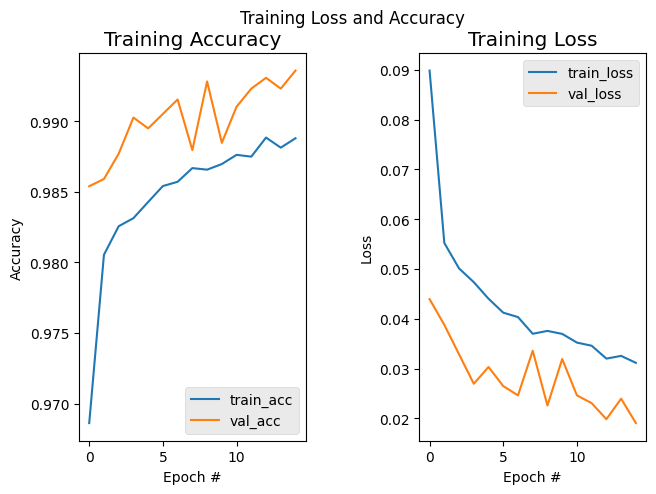

<Figure size 640x480 with 0 Axes>

In [17]:
# reset the testing generator and evaluate the network after
# fine-tuning just the network head
print("[INFO] evaluating after fine-tuning network head...")
testGen.reset()
predIdxs = model.predict(x=testGen, steps=(totalTest // BATCH_SIZE) + 1)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testGen.classes, predIdxs,target_names=testGen.class_indices.keys()))

if not os.path.exists(BASE_CSV_PATH):
    os.makedirs(BASE_CSV_PATH)
plot_training(H, 15, WARMUP_PLOT_PATH)

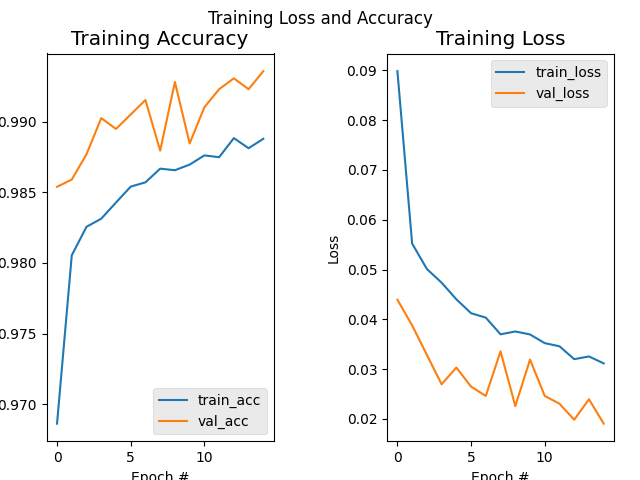

In [18]:
# Display The Image
import IPython.display as display
from PIL import Image
display.display(Image.open(WARMUP_PLOT_PATH))

In [19]:
# reset our data generators
trainGen.reset()
valGen.reset()
# now that the head FC layers have been trained/initialized, lets
# unfreeze the final set of CONV layers and make them trainable
for layer in baseModel.layers[:165]:
    layer.trainable = False
for layer in baseModel.layers[165:]:
    layer.trainable = True
# loop over the layers in the model and show which ones are trainable
# or not

for i, layer in enumerate(baseModel.layers):
    print("{}: {}    [{}]".format(i, layer.name, layer.trainable))

0: input_1    [False]
1: conv1_pad    [False]
2: conv1_conv    [False]
3: conv1_bn    [False]
4: conv1_relu    [False]
5: pool1_pad    [False]
6: pool1_pool    [False]
7: conv2_block1_1_conv    [False]
8: conv2_block1_1_bn    [False]
9: conv2_block1_1_relu    [False]
10: conv2_block1_2_conv    [False]
11: conv2_block1_2_bn    [False]
12: conv2_block1_2_relu    [False]
13: conv2_block1_0_conv    [False]
14: conv2_block1_3_conv    [False]
15: conv2_block1_0_bn    [False]
16: conv2_block1_3_bn    [False]
17: conv2_block1_add    [False]
18: conv2_block1_out    [False]
19: conv2_block2_1_conv    [False]
20: conv2_block2_1_bn    [False]
21: conv2_block2_1_relu    [False]
22: conv2_block2_2_conv    [False]
23: conv2_block2_2_bn    [False]
24: conv2_block2_2_relu    [False]
25: conv2_block2_3_conv    [False]
26: conv2_block2_3_bn    [False]
27: conv2_block2_add    [False]
28: conv2_block2_out    [False]
29: conv2_block3_1_conv    [False]
30: conv2_block3_1_bn    [False]
31: conv2_block3_1_relu

In [20]:
# for the changes to the model to take affect we need to recompile
# the model, this time using SGD with a *very* small learning rate
print("[INFO] re-compiling model...")
opt = Adam(learning_rate=INIT_LR)  # Remove the 'decay' parameter
#opt = Adam(lr=INIT_LR, decay=INIT_LR / 25)
#opt = SGD(lr=1e-4, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
# train the model again, this time fine-tuning *both* the final set
# of CONV layers along with our set of FC layers
H = model.fit(
    x=trainGen,
    steps_per_epoch=totalTrain // BATCH_SIZE,
    validation_data=valGen,
    validation_steps=totalVal // BATCH_SIZE,
    epochs=5)

[INFO] re-compiling model...
Epoch 1/5
1965/1965 [==============================] - 848s 428ms/step - loss: 0.0374 - accuracy: 0.9873 - val_loss: 0.0470 - val_accuracy: 0.9892
Epoch 2/5
1965/1965 [==============================] - 835s 425ms/step - loss: 0.0284 - accuracy: 0.9897 - val_loss: 0.0170 - val_accuracy: 0.9944
Epoch 3/5
1965/1965 [==============================] - 831s 423ms/step - loss: 0.0248 - accuracy: 0.9908 - val_loss: 0.0218 - val_accuracy: 0.9918
Epoch 4/5
1965/1965 [==============================] - 840s 427ms/step - loss: 0.0239 - accuracy: 0.9913 - val_loss: 0.0211 - val_accuracy: 0.9918
Epoch 5/5
1965/1965 [==============================] - 840s 428ms/step - loss: 0.0217 - accuracy: 0.9922 - val_loss: 0.0206 - val_accuracy: 0.9931


[INFO] evaluating after fine-tuning network...
123/123 [==============================] - 17s 134ms/step
              precision    recall  f1-score   support

   NonSelfie       0.99      0.99      0.99      1966
      Selfie       0.99      0.99      0.99      1966

    accuracy                           0.99      3932
   macro avg       0.99      0.99      0.99      3932
weighted avg       0.99      0.99      0.99      3932



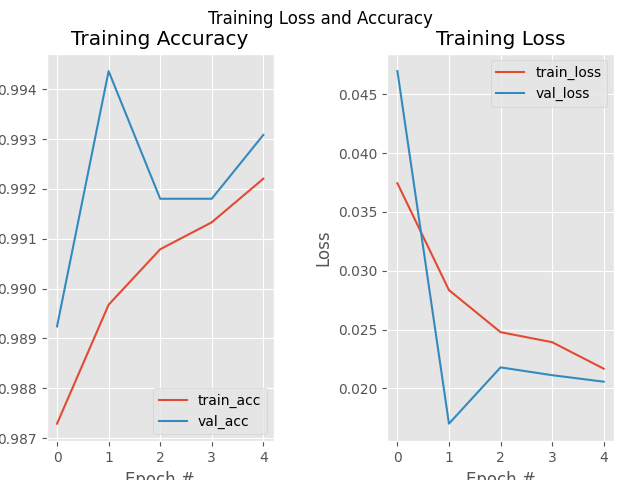

[INFO] serializing network...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


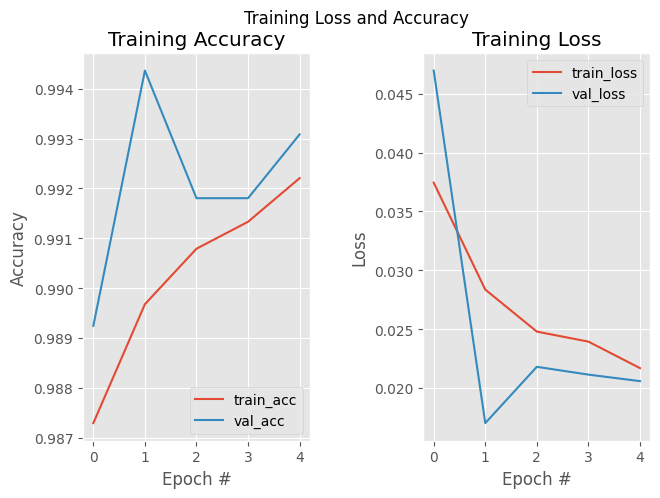

<Figure size 640x480 with 0 Axes>

In [22]:
# reset the testing generator and then use our trained model to
# make predictions on the data
print("[INFO] evaluating after fine-tuning network...")
testGen.reset()
predIdxs = model.predict(x=testGen, steps=(totalTest // BATCH_SIZE) + 1)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testGen.classes, predIdxs, target_names=testGen.class_indices.keys()))
plot_training(H, 5, UNFROZEN_PLOT_PATH)
display.display(Image.open(UNFROZEN_PLOT_PATH))
# serialize the model to disk
print("[INFO] serializing network...")
model.save(MODEL_PATH, save_format="h5")

Making predictions with fine-tuning and Keras

In [23]:
# import the necessary packages
from tensorflow.keras.models import load_model
import numpy as np
import imutils
import cv2

In [46]:
p = os.path.sep.join([BASE_PATH, TEST])
imagePaths = list(paths.list_images(p))
# load the input image and then clone it so we can draw on it later
image = cv2.imread(imagePaths[2200]) # Image Path
output = image.copy()
output = imutils.resize(output, width=400)
# our model was trained on RGB ordered images but OpenCV represents
# images in BGR order, so swap the channels, and then resize to
# 224x224 (the input dimensions for VGG16)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (224, 224))
# convert the image to a floating point data type and perform mean
# subtraction
image = image.astype("float32")
mean = np.array([123.68, 116.779, 103.939][::-1], dtype="float32")
image -= mean

In [47]:
import cv2
from google.colab.patches import cv2_imshow
CLASSES = ["NonSelfie", "Selfie"]

[INFO] loading model...
1/1 [==============================] - 1s 898ms/step
Preds: [4.6398554e-06 9.9999535e-01]


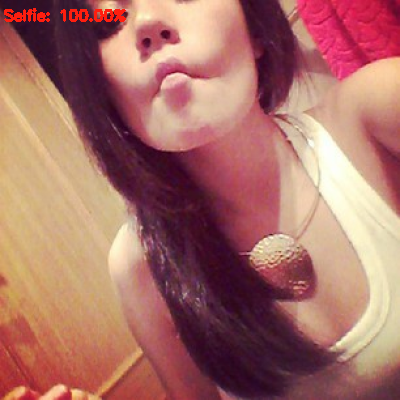

**********


In [48]:
# load the trained model from disk
print("[INFO] loading model...")
model = load_model(MODEL_PATH)
# pass the image through the network to obtain our predictions
preds = model.predict(np.expand_dims(image, axis=0))[0]
print(f"Preds: {preds}")
i = np.argmax(preds)
label = CLASSES[i]
# draw the prediction on the output image
text = "{}: {:.2f}%".format(label, preds[i] * 100)
cv2.putText(output, text, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (15, 30, 255), 2)
# show the output image
cv2_imshow(output)
cv2.waitKey(0)
print("**********")

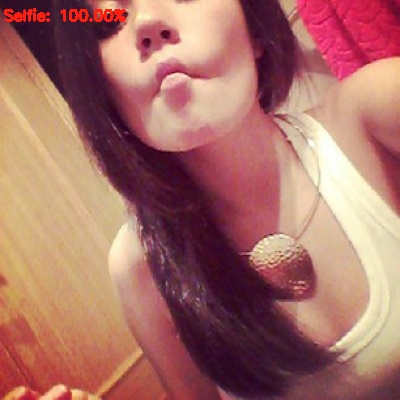

In [49]:
filename = join('./','savedImage.jpg')
# Using cv2.imwrite() method
# Saving the image
cv2.imwrite(filename, output)

# Display The Image
display.display(Image.open(filename))